# Импорт и загрузка данных

In [ ]:
! pip install catboost
! pip install feature_engine
! pip install pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
from catboost import CatBoostClassifier

%matplotlib inline

In [ ]:
RESOLUTION = 8

In [ ]:
data_8 = os.path.join("sample_data", "training_data_y.xlsx")
data = pd.read_excel(os.path.join(data_8))
data_org = data.copy()
# first drop the h3, lat and lng attributes
data.drop(columns=['h3', 'lat', 'lng'], inplace=True)
# consider this as a classification problem
data['y'] = (data['y'] > 0).astype(int)
data = data.astype(int)

In [ ]:
y = data['y']
data.pop('y')
from sklearn.model_selection import train_test_split
df_train, df_test, y_train , y_test = train_test_split(data, y, test_size=0.2, random_state=11, stratify=y)
df = df_train.copy()

# Общие функции

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
# define a function to apply the same function on both train and test datasets
def apply(function, df_train, df_test, axis=1):
    df_train = df_train.apply(function, axis=axis)
    df_test = df_test.apply(function, axis=axis)
    return df_train, df_test

def drop(cols, df_train, df_test):
    if isinstance(cols, str):
        cols = [cols]
    return df_train.drop(columns=cols), df_test.drop(columns=cols)    

In [ ]:
def divide(a, b):
    return a / b if b != 0 else 0

In [ ]:
def pdf_feat(df, col):
    sns.displot(df, x=col, hue='y', palette='dark')
    plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    # discrete features are the ones with type int
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]

    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def mi_scores(x, y):
    mi_scores = make_mi_scores(x, y)
    plot_mi_scores(mi_scores)
    plt.show()

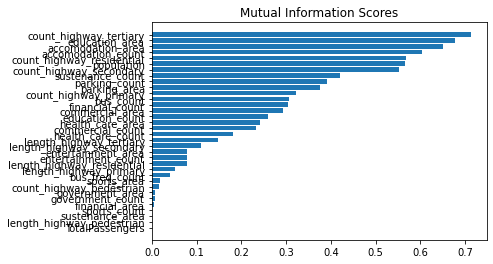

In [ ]:
mi_scores(df, y_train)

# Нормализация данных

In [ ]:
for c in df.columns:
    if len(df[df[c] != 0]) == 0:
        print(c)

In [ ]:
out_dict = {}
for c in df.columns:
    # for each column: filter by rows who do not have zero at that column and retrive the column
    q3, q1 = np.percentile(df[df[c] != 0][c], [75, 25])
    iqr = q3 - q1
    min_v = q1 - 1.5 * iqr
    max_v = q3 + 1.5 * iqr
    out_dict[c] = (min_v, max_v)


cols = df.columns
def fix_outliers(row):
    for c in cols:
        v = row[c]
        min_v, max_v = out_dict[c]
        if v != 0 and v > max_v:
            row[c] = max_v
        elif v != 0 and v < min_v:
            row[c] = min_v
    return row

df_t = df.apply(fix_outliers, axis=1)

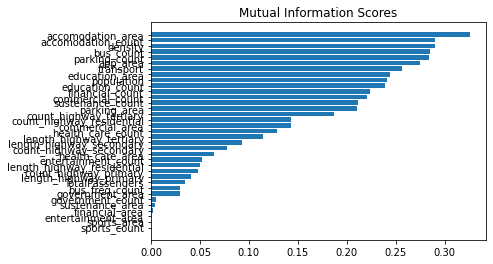

In [ ]:
bus_s = 'bus_count'
bus_f = 'bus_freq_count'
metro  = 'TotalPassengers'
def set_tranport(row):
    row['transport'] = (row[bus_s] + 2) * np.sqrt(np.log(row[bus_f] + 2) ) + row[metro]
    return row

a_a = 'accomodation_area'
a_c = 'accomodation_count'
pop = 'population'

def get_acc_feats(row):
    row['density'] = divide(row[pop], row[a_a])
    row['app_area'] = divide(row[a_a], row[a_c]) 
    row[a_a] / row[a_c] if row[a_c] != 0 else 0
    return row
# set accomodation and transport
df, df_test = apply(get_acc_feats, df, df_test)
df, df_test = apply(set_tranport, df, df_test)

df, df_test = drop(["count_highway_pedestrian", "length_highway_pedestrian"], df, df_test)

mi_scores(df, y_train)


In [ ]:
def display_correlation(df, threshold=0.2):
    r = df.corr(method="spearman")
    r_display = r[(r['y'] > threshold) | (r['y'] < -threshold)]
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(r_display, vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    plt.show()
    return(r)


## Применение необходимых преобразований

In [ ]:
import scipy.stats as st
# first let's drop some columns:
drop_columns = ["financial_area", "health_care_area", "entertainment_area", "sustenance_area", 
                "sports_count", "sports_area", "government_area", "government_count", metro, bus_f]

box_cox_cols = ["education_area", "parking_area", "accomodation_count", "accomodation_area",
                 "count_highway_secondary", "length_highway_secondary",
                "count_highway_residential", "density", "app_area", "length_highway_tertiary"]
discretize_cols = ["count_highway_primary", "length_highway_primary", "education_count", "financial_count", "commercial_count", "commercial_area", "health_care_count", 
                   "sustenance_count", "length_highway_secondary", "length_highway_tertiary", "length_highway_residential"]

df, df_test = drop(drop_columns, df, df_test)


In [ ]:
# # трансформация с помощью box cox
for c in box_cox_cols:
    df[c] ,_params = st.boxcox(df[c] + 1)
    df_test[c] = st.boxcox(df_test[c] + 1, _params)            

In [ ]:
# дискретизировать
from feature_engine.discretisation import DecisionTreeDiscretiser
discretize_cols
disc = DecisionTreeDiscretiser(cv=3, param_grid={"max_depth": [2, 3], "random_state":[11]} , random_state=11, scoring='precision', variables=discretize_cols, regression=False)

# fit the transformer
df_t= disc.fit_transform(df, y_train)
df_test_t = pd.DataFrame(disc.transform(df_test), columns=df_test.columns)

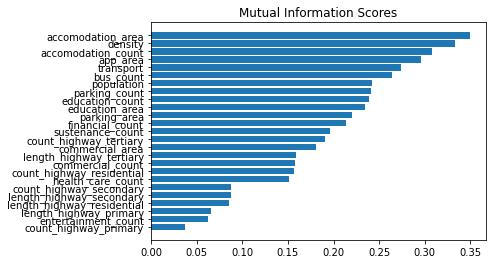

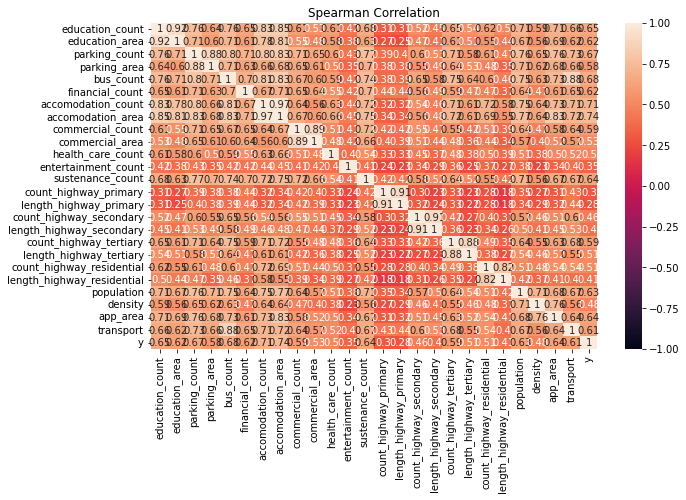

,education_count,education_area,parking_count,parking_area,bus_count,financial_count,accomodation_count,accomodation_area,commercial_count,commercial_area,...,length_highway_secondary,count_highway_tertiary,length_highway_tertiary,count_highway_residential,length_highway_residential,population,density,app_area,transport,y
education_count,1.000000,0.922341,0.760406,0.636980,0.756019,0.648063,0.829601,0.850917,0.608721,0.532314,...,0.451659,0.648428,0.540037,0.615347,0.504553,0.705591,0.590236,0.709952,0.664531,0.653209
education_area,0.922341,1.000000,0.711532,0.599543,0.714081,0.607149,0.776905,0.806023,0.546036,0.475266,...,0.409563,0.606329,0.511009,0.546878,0.444956,0.671120,0.559820,0.685584,0.619019,0.619189
parking_count,0.760406,0.711532,1.000000,0.883082,0.803581,0.706565,0.799704,0.828186,0.712478,0.649699,...,0.527999,0.708662,0.581963,0.606911,0.465353,0.764610,0.648385,0.758239,0.731931,0.673860
parking_area,0.636980,0.599543,0.883082,1.000000,0.712232,0.628282,0.655521,0.684269,0.651213,0.606522,...,0.492036,0.643042,0.532699,0.484167,0.352829,0.706752,0.615052,0.682146,0.662901,0.582775
bus_count,0.756019,0.714081,0.803581,0.712232,1.000000,0.700999,0.806288,0.828325,0.665906,0.595322,...,0.577696,0.750065,0.639190,0.597882,0.460234,0.749416,0.627793,0.727232,0.876529,0.675613
financial_count,0.648063,0.607149,0.706565,0.628282,0.700999,1.000000,0.670461,0.710359,0.653366,0.638800,...,0.485782,0.589679,0.466488,0.471016,0.372180,0.635680,0.473345,0.606456,0.651038,0.615005
accomodation_count,0.829601,0.776905,0.799704,0.655521,0.806288,0.670461,1.000000,0.967784,0.641353,0.561998,...,0.459947,0.710164,0.605325,0.718279,0.580860,0.745331,0.644801,0.733111,0.710717,0.710698
accomodation_area,0.850917,0.806023,0.828186,0.684269,0.828325,0.710359,0.967784,1.000000,0.674103,0.598579,...,0.481807,0.722025,0.613075,0.688779,0.552720,0.772517,0.640456,0.827120,0.722447,0.743185
commercial_count,0.608721,0.546036,0.712478,0.651213,0.665906,0.653366,0.641353,0.674103,1.000000,0.886633,...,0.467717,0.552526,0.421813,0.508741,0.388153,0.636865,0.473202,0.584821,0.636844,0.586682
commercial_area,0.532314,0.475266,0.649699,0.606522,0.595322,0.638800,0.561998,0.598579,0.886633,1.000000,...,0.435224,0.484242,0.363481,0.437599,0.335046,0.566695,0.401836,0.516097,0.574909,0.526360


In [ ]:
mi_scores(df_t, y_train)
df_t['y'] = y_train
display_correlation(df_t)

In [ ]:
df_t.pop('y')
df = df_t.copy()
df_test = df_test_t.copy()

In [ ]:
df.columns

Index(['education_count', 'education_area', 'parking_count', 'parking_area',
       'bus_count', 'financial_count', 'accomodation_count',
       'accomodation_area', 'commercial_count', 'commercial_area',
       'health_care_count', 'entertainment_count', 'sustenance_count',
       'count_highway_primary', 'length_highway_primary',
       'count_highway_secondary', 'length_highway_secondary',
       'count_highway_tertiary', 'length_highway_tertiary',
       'count_highway_residential', 'length_highway_residential', 'population',
       'density', 'app_area', 'transport'],
      dtype='object')

In [ ]:
# applying PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
pca = PCA(n_components=0.95)

df_s = pd.DataFrame(ss.fit_transform(df), columns=df.columns)
df_test_s = pd.DataFrame(ss.transform(df_test), columns=df_test.columns)

df_p = pd.DataFrame(pca.fit_transform(df_s))
df_test_p = pd.DataFrame(pca.transform(df_test_s))

df = df_p.copy()
df_test = df_test_p.copy()

In [ ]:
import pickle


# Hyperparameter Tuning and choosing the model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
import pickle


CV = StratifiedKFold(n_splits=5) 
ll_score = make_scorer(log_loss,greater_is_better=True, needs_proba=True)

In [ ]:
metrics = [accuracy_score, recall_score, precision_score]

In [ ]:
def hypertune_model(estimator, params:dict,estimator_name,  X_train, y_train, X_test, y_test, 
                    cv=None, polys=None, random=False, ll=False):
    if polys is None:
        polys = [1, 2, 3]
    
    if cv is None:
        cv = CV
        
    steps = [('scaler', StandardScaler()) 
            ,('poly_feats', PolynomialFeatures())
            , ('estimator', estimator)]

    new_params = {} 
    new_params['poly_feats__degree'] = polys
    
    for k, v in params.items():
        new_params['estimator__' + k] = v
    pipe = Pipeline(steps=steps)
    scoring = {"precision": "precision" ,  "log_loss": ll_score}
        
    if ll:
        if random:
            search = RandomizedSearchCV(pipe, new_params, scoring=scoring, refit='log_loss')
        else:
            search = GridSearchCV(pipe, new_params, scoring=scoring, refit='log_loss')
    else:
        if random:
            search = RandomizedSearchCV(pipe, new_params, scoring='precision')
        else:
            search = GridSearchCV(pipe, new_params, scoring='precision')
              
    search.fit(X_train, y_train)
    best_est, best_para = search.best_estimator_, search.best_params_
    ll = 0
    
    try:
        y_pred = best_est.predict_proba(X_test)
        ll = log_loss(y_test, list(y_pred[:, 1]))
    except:
        ll = 0

    y_pred = best_est.predict(X_test)
    pre = precision_score(y_test, y_pred)

    pickle.dump(best_est, open(f"{estimator_name}.sav", 'wb'))
    return best_est, best_para, search.cv_results_, ll, pre

In [ ]:
def display_cv_res(cv_est, cv_res, est_name):
    for k, v in cv_res.items(): 
        if "test" in k:
            print(f"{k}\t{v.mean()}")
    with open('to_save.txt', "a") as f:
        f.write("\n" + str(cv_res) + "\n")
 

In [ ]:
from sklearn.linear_model import LogisticRegression

lasso_param = {"C": np.logspace(-3, 2, 40)}
lasso_param = {"C": [0.1]}
lasso = LogisticRegression(max_iter=3000, penalty='l1', solver='saga')

lasso_pack = hypertune_model(lasso, lasso_param , "Lasso", df, y_train, df_test, y_test)
lasso_ll = lasso_pack[-2]
lasso_pre = lasso_pack[-1]

print(f"Lasso_test_loss_score: {lasso_ll}\nLasso_test_precision:{lasso_pre}")


Lasso_test_loss_score: 0.2862453393735955
Lasso_test_precision:0.865


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
def f(best_est, X_test, y_test):
    try:
      y_pred = best_est.predict_proba(X_test)
      ll = log_loss(y_test, list(y_pred[:, 1]))
    except:
      ll = 0  
    y_pred = best_est.predict(X_test)
    pre = precision_score(y_test, y_pred)
    return ll, pre


In [ ]:
import pickle
lasso = pickle.load(open("sample_data/Lasso.sav", 'rb'))

lasso_ll, lasso_pre = f(lasso, df_test, y_test)

print(f"Lasso_test_loss_score: {lasso_ll}\nLasso_test_precision:{lasso_pre}")


Lasso_test_loss_score: 0.2862453393735955
Lasso_test_precision:0.865


In [ ]:
from sklearn.linear_model import RidgeClassifier

ridge_param = {"alpha": np.logspace(-3, 2, 40)}

# ridge_param = {"alpha": [0.1]}

ridge = RidgeClassifier(max_iter=5000)
ridge_pack = hypertune_model(ridge, ridge_param, "ridge", df, y_train, df_test, y_test)

ridge_ll = ridge_pack[-2]
ridge_pre = ridge_pack[-1]

# ridge does not suppoer predict_proba (thus, can't be used in our approach)

print(f"Ridge_test_loss_score: {ridge_ll}\nRidge_test_precision:{ridge_pre}")



Ridge_test_loss_score: 0
Ridge_test_precision:0.8652849740932642


### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True) 
svm_params = {'C': np.logspace(-1, 2, 20), 'gamma':  np.logspace(-3, -1, 10)}
svm_pack = hypertune_model(svm, svm_params, "SVM",df, y_train, df_test, y_test, polys=[1], ll=True)

svm = pickle.load(open("sample_data/svm.sav", 'rb'))

svm_ll, svm_pre = f(svm, df_test, y_test)

print(f"Support_Vector_Machine_test_loss_score: {ridge_ll}\nSupport_Vector_Machine_test_precision:{ridge_pre}")


In [ ]:
print(svm_pack)

In [ ]:
svm = pickle.load(open("sample_data/SVM.sav", 'rb'))

lasso_ll, lasso_pre = f(svm, df_test, y_test)

print(f"SVM_test_loss_score: {lasso_ll}\nSVM_test_precision: {lasso_pre}")


SVM_test_loss_score: 0.42983308260620673
SVM_test_precision:0.8206521739130435


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_params = {"weights": ["distance"], "n_neighbors":list(range(11, 31, 2))}

knn_pack = hypertune_model(knn, knn_params, "KNN", df, y_train, df_test, y_test, ll=True)
knn_ll = knn_pack[-2]
knn_pre = knn_pack[-1]

print(f"KNearestNeighbors_test_loss_score: {knn_ll}\nKNearestNeighbors_test_precision:{knn_pre}")

KNearestNeighbors_test_loss_score: 1.023841367147584
KNearestNeighbors_test_precision:0.84375


## CatBoost Classifier

In [ ]:
ctb_params = {'depth'         : [4,5,6],
              'learning_rate' : np.linspace(0.01, 0.1, 5),
              'iterations'    : [50,60,70],
              'loss_function': ['Logloss'],
              'random_state': [42]
              }

ctb = CatBoostClassifier(verbose=False)

ctb_pack = hypertune_model(ctb, ctb_params, "CTB", df, y_train, df_test, y_test)

ctb_ll, ctb_pre = ctb_pack[-2], ctb_pack[-1]

ctb = pickle.load(open("sample_data/best_model.sav", 'rb'))

ctb_ll, ctb_pre = f(ctb, df_test, y_test)

print(f"CatBoostClassifier_test_loss_score: {ctb_ll}\nCatBoostClassifier_test_precision:{ctb_pre}")




In [ ]:
ctb = pickle.load(open("sample_data/best_model.sav", 'rb'))

lasso_ll, lasso_pre = f(ctb, df_test, y_test)

print(f"CatBoostClassifier_test_loss_score: {lasso_ll}\nCatBoostClassifier_test_precision:{lasso_pre}")


CatBoostClassifier_test_loss_score: 0.27297888802643067
CatBoostClassifier_test_precision:0.8725490196078431


## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rdf_params = {"max_depth": list(range(2, 6)), 
              "n_estimators":[100, 150, 200, 220], 
              "min_samples_leaf":list(np.linspace(0.02, 0.1, 6)), "max_samples": [0.8, 0.85, 0.9]}

rdf = RandomForestClassifier() 

rdf_pack = hypertune_model(rdf, rdf_params, "RDF", df, y_train, df_test, y_test)

rdf_ll, rdf_pre = rdf_pack[-2], rdf_pack[-1]

print(f"RandomForestClassifier_test_loss_score: {rdf_ll}\nRandomForestClassifier_test_precision:{rdf_pre}")


RandomForestClassifier_test_loss_score: 0.3301044813638794
RandomForestClassifier_test_precision:0.8509615384615384
